In [1]:
import sys
import xarray as xr
import pandas as pd
from pathlib import Path
from pyswmm import Simulation, Nodes, Output, SimulationPreConfig
from pyswmm import Simulation, Nodes, Links, Subcatchments, SystemStats, Simulation
import matplotlib.pyplot as plt
from swmm.toolkit import shared_enum

sys.path.append(r'C:\Users\everett\Documents\GitHub\camus_to')


data_file = r"C:\Users\everett\Documents\GitHub\camus_to\data\clean\camus_to.nc"

from swmmio import Model

array([[54]])

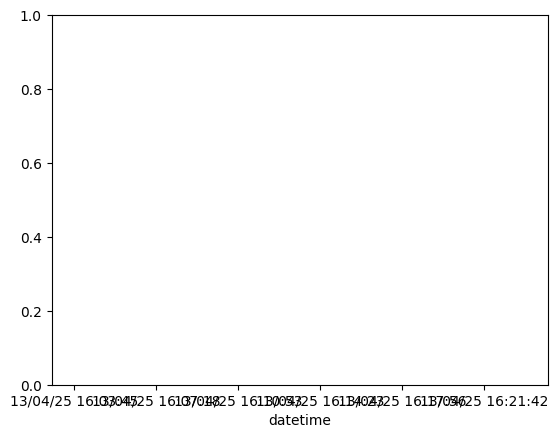

In [314]:
from utils.runutils import summarize_runs
model_name = "HY006"
run_folder = Path(rf"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\{model_name}\runs")
subfolders = [f.name for f in run_folder.iterdir() if f.is_dir()]

run_dir = summarize_runs(run_folder).sort_values(by="dates").index[-1]


#def plot_run_score(run_dir):
scores_file = run_dir / "results_scores.txt"
scores_df = pd.read_csv(scores_file, sep=",", header=0, index_col=0)  # Adjust the separator if necessary

param_file = run_dir / "results_params.txt"
params_df = pd.read_csv(param_file, sep=",", index_col=0)  # Adjust the separator if necessary

import matplotlib.pyplot as plt


ax = scores_df["score"].plot()
ax.set_ylim(0,1)
import numpy as np
import shutil
np.argwhere(scores_df["score"].values == scores_df["score"].max())



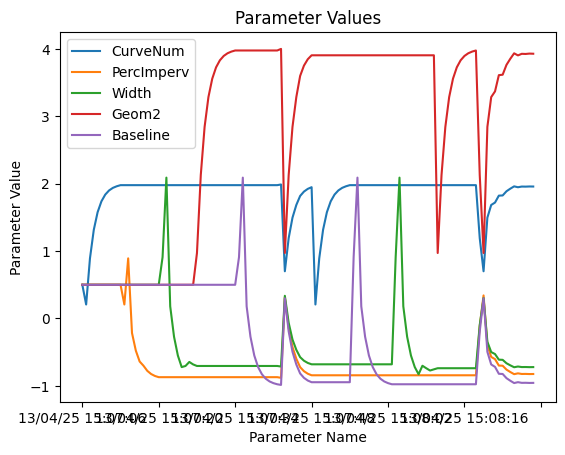

In [307]:
params = params_df["attribute"].unique()

fig, ax = plt.subplots()
for param in params:
    params_df[params_df["attribute"] == param]["cal_val"].plot(ax=ax)
ax.set_title("Parameter Values")
ax.set_ylabel("Parameter Value")
ax.set_xlabel("Parameter Name")
plt.legend(params)


In [3]:
from utils.optconfig import OptConfig
from utils.swmmutils import set_model_datetimes
model_file = base_model_dir / "calibrated_model.inp"

oc = OptConfig(config_file=run_dir / "config.yml", model_file=model_file)
oc.validation_end_date

Timestamp('2021-03-03 13:15:00')

In [7]:
cal_params = params_df[params_df["iter"] == 3000]
cal_params

,iter,section,...,init_val,cal_val
datetime,,,,,
11/04/25 04:18:38,3000,infiltration,...,95.000000,51.143089
11/04/25 04:18:38,3000,subcatchments,...,80.132500,40.093406
11/04/25 04:18:38,3000,subcatchments,...,80.132500,40.093406
11/04/25 04:18:38,3000,subcatchments,...,80.132500,41.829312
11/04/25 04:18:38,3000,subcatchments,...,80.132500,40.093406
...,...,...,...,...,...
11/04/25 04:18:38,3000,subcatchments,...,80.132500,52.651751
11/04/25 04:18:38,3000,subcatchments,...,171.548673,142.414413
11/04/25 04:18:38,3000,subcatchments,...,12.358565,0.667468


Looks at model directory, runs all uncalibrated models and plots result versus target data

In [253]:
model_dir = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm")
station_ids = [f.stem for f in model_dir.iterdir()]
station_ids

['HY005',
 'HY006',
 'HY010',
 'HY013',
 'HY014',
 'HY017',
 'HY018',
 'HY019',
 'HY022',
 'HY023',
 'HY024',
 'HY026',
 'HY027',
 'HY028',
 'HY034',
 'HY035',
 'HY040',
 'HY044',
 'HY045',
 'HY047',
 'HY048',
 'HY051',
 'HY052',
 'HY053',
 'HY054',
 'HY059',
 'HY060',
 'HY062',
 'HY065',
 'HY066',
 'HY067',
 'HY068',
 'HY079',
 'HY080',
 'HY081',
 'HY082',
 'HY084',
 'HY089',
 'HY090',
 'HY091',
 'HY092',
 'HY093',
 'HY095',
 'HY097',
 'HY098',
 'HY100',
 'HY101',
 'HY103',
 'HY104',
 'HY112',
 'HY116',
 'HY118',
 'HY119',
 'HY120',
 'HY123']


... SWMM Version 5.2.4
... Run Completestation                    obs_discharge(cms)
datetime                                     
2012-11-22 11:00:00+00:00            0.658642
2012-11-22 11:15:00+00:00            0.658642
2012-11-22 11:30:00+00:00            0.658642
2012-11-22 11:45:00+00:00            0.658642
2012-11-22 12:00:00+00:00            0.658642
...                                       ...
2021-02-05 10:00:00+00:00            2.484367
2021-02-05 10:15:00+00:00            2.464245
2021-02-05 10:30:00+00:00            2.444208
2021-02-05 10:45:00+00:00            2.424255
2021-02-05 11:00:00+00:00            2.384491

[287713 rows x 1 columns]


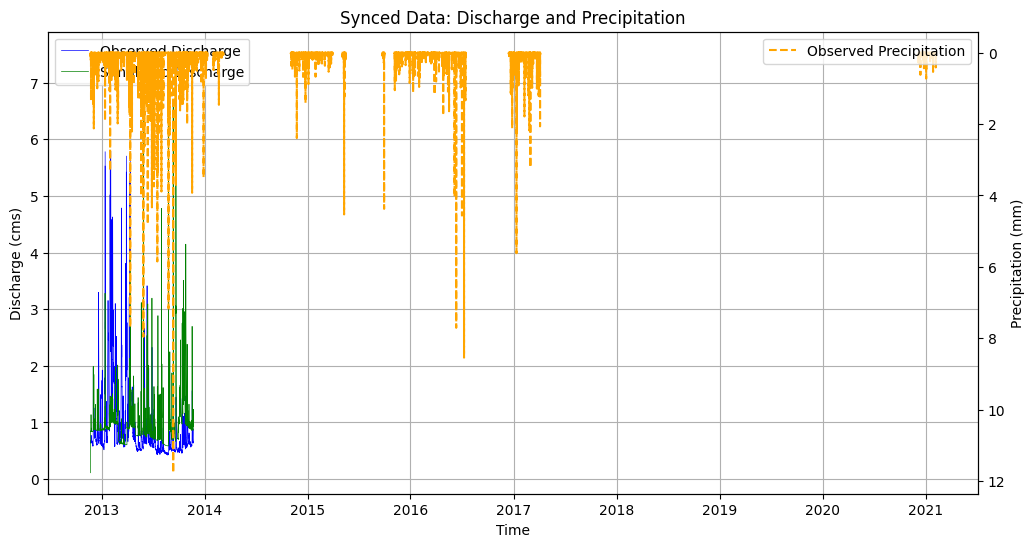

In [100]:
model_dirs = [dir for dir in Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm").iterdir() if dir.is_dir()]


for dir in model_dirs[9:10]:    
    model_name = dir.name
    model_file = (dir / f"{model_name}_cal_mod").with_suffix(".inp")
    qobs = pd.read_pickle(dir / "targets.pkl")["discharge(cms)"]
    qobs.rename(columns={qobs.columns[0]: "obs_discharge(cms)"}, inplace=True)
    pobs = pd.read_pickle(dir / "forcings.pkl")["precipitation(mm)"]
    pobs.rename(columns={pobs.columns[0]: "obs_precip(mm)"}, inplace=True)


    with Simulation(str(model_file)) as sim:
        sim.execute()

        

        print(qobs)
    with Output(str(model_file.with_suffix(".out"))) as output:
        qsim = output.node_series(model_name, attribute=shared_enum.NodeAttribute.TOTAL_INFLOW)
    

# Convert qsim to a DataFrame for easier synchronization
qsim = pd.DataFrame.from_dict(qsim, orient='index', columns=['qsim'])
qsim.rename(columns={qsim.columns[0]: 'sim_discharge(cms)'}, inplace=True)

# Remove timezone information from qobs
qobs = qobs.tz_localize(None)

pobs = pobs.tz_localize(None)

# Synchronize qobs and qsim by aligning their indices
qobs, qsim = qobs.align(qsim, join='inner', axis=0)

# Combine into a single DataFrame for comparison
synced_data = pd.concat([qobs, qsim, pobs], axis=1)



fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot discharge data on the primary y-axis
ax1.plot(synced_data.index, synced_data["obs_discharge(cms)"], label="Observed Discharge", color="blue", linewidth=0.5)
ax1.plot(synced_data.index, synced_data["sim_discharge(cms)"], label="Simulated Discharge", color="green", linewidth=0.5)
ax1.set_xlabel("Time")
ax1.set_ylabel("Discharge (cms)")
ax1.legend(loc="upper left")
ax1.grid()

# Create a secondary y-axis for precipitation
ax2 = ax1.twinx()
ax2.plot(synced_data.index, synced_data["obs_precip(mm)"], label="Observed Precipitation", color="orange", linestyle="--")
ax2.set_ylabel("Precipitation (mm)")
ax2.invert_yaxis()  # Reverse the y-axis
ax2.legend(loc="upper right")

plt.title("Synced Data: Discharge and Precipitation")
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\everett\\Documents\\GitHub\\camus_to\\data\\models\\swmm\\HY006\\runs\\run-semidist-1yr_09-04-25-233448\\opt_config.yaml'

In [265]:
model_name = "HY006"
run_folder = Path(rf"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\{model_name}\runs")
subfolders = [f.name for f in run_folder.iterdir() if f.is_dir()]



run_dir = run_folder / subfolders[-1]
scores_file = run_dir / "results_scores.txt"
scores_df = pd.read_csv(scores_file, sep=",", header=0)  # Adjust the separator if necessary

param_file = run_dir / "results_params.txt"
params_df = pd.read_csv(param_file, sep=",")  # Adjust the separator if necessary

import matplotlib.pyplot as plt

ax = scores_df["score"].plot()


TypeError: no numeric data to plot

TypeError: no numeric data to plot

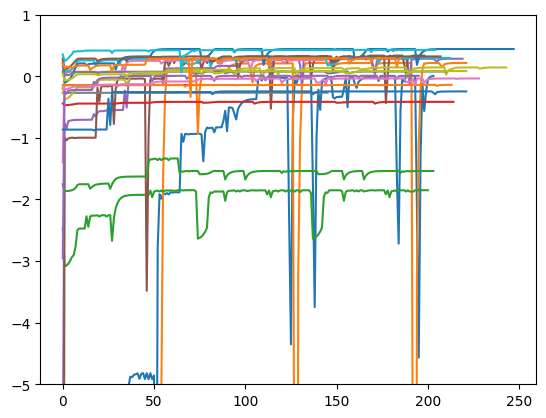

In [ ]:
import pandas as pd

for model_dir in Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm").iterdir():

    run_folder = Path(rf"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\{model_dir.stem}\runs")
    subfolders = [f.name for f in run_folder.iterdir() if f.is_dir()]

    run_dir = run_folder / subfolders[-1]
    scores_file = run_dir / "results_scores.txt"
    scores_df = pd.read_csv(scores_file, sep=",", header=0)  # Adjust the separator if necessary

    param_file = run_dir / "results_params.txt"
    params_df = pd.read_csv(param_file, sep=",")  # Adjust the separator if necessary

    import matplotlib.pyplot as plt

    ax = scores_df["score"].plot()
    ax.set_ylim(-5, 1)

In [81]:

targets_df = pd.read_pickle(model_dir / "HY006" / "targets.pkl")
targets_df.index = targets_df.index.tz_localize(None)
targets_df

,stage(m),discharge(cms)
station,HY006,HY006
time,,
2015-01-01 00:15:00,0.288,0.375809
2015-01-01 00:30:00,0.292,0.373330
2015-01-01 00:45:00,0.293,0.368400
2015-01-01 01:00:00,0.294,0.363498
2015-01-01 01:15:00,0.290,0.358622
...,...,...
2021-02-03 12:45:00,0.226,0.241614
2021-02-03 13:00:00,0.229,0.247658


In [312]:
run_dir

WindowsPath('C:/Users/everett/Documents/GitHub/camus_to/data/models/swmm/HY017/runs/run-semidist-1yr-v3_13-04-25-150706')

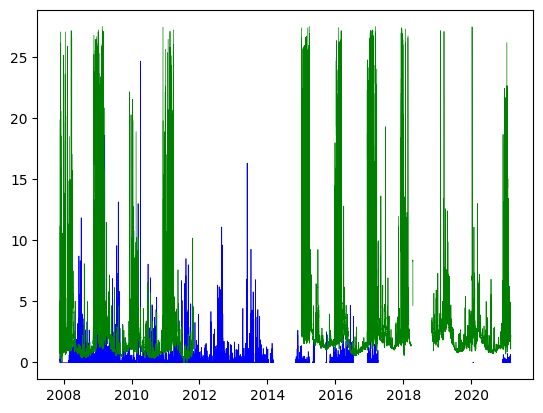

In [324]:
precip = pd.read_pickle(model_dir / "HY006" / "forcings.pkl")["precipitation(mm)"].tz_localize(None)

obs = pd.read_pickle(model_dir / "HY006" / "targets.pkl")["discharge(cms)"].tz_localize(None)

plt.plot(precip.index, precip.values, label="Observed Precipitation", color="blue", linewidth=0.5)
plt.plot(obs.index, obs.values, label="Observed Discharge", color="green", linewidth=0.5)

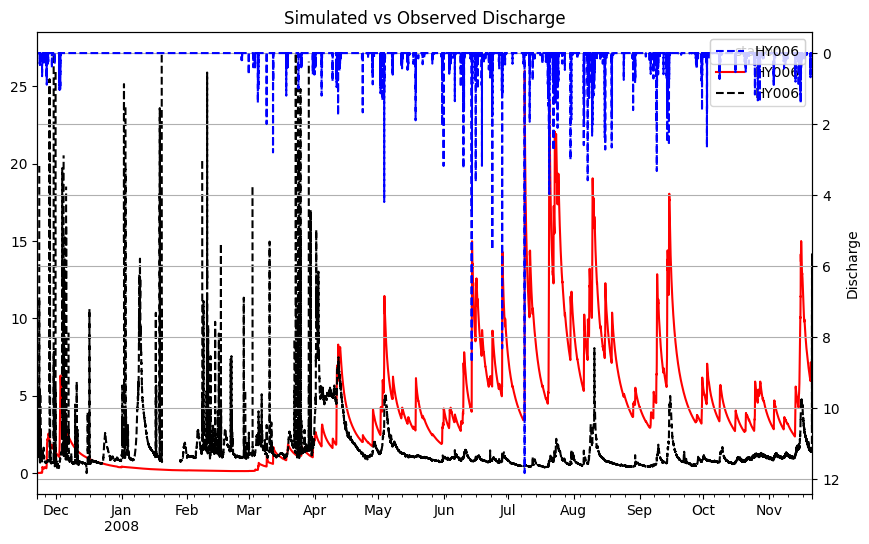

In [322]:
iter = 50

sim = pd.read_pickle(run_dir / "timeseries" / f"sim_{iter}.pkl")
obs = pd.read_pickle(run_dir / "timeseries" / f"obs_{iter}.pkl")

precip = pd.read_pickle(model_dir / "HY006" / "forcings.pkl")["precipitation(mm)"].tz_localize(None)
fig, ax = plt.subplots(figsize=(10, 6))
sim["discharge(cms)"].plot(ax=ax, label="Simulated Discharge (HY095)", color="red")
obs["discharge(cms)"].plot(ax=ax, label="Observed Discharge (HY095)", color="black", linestyle="--")
ax2 = ax.twinx()

precip.loc[slice(obs.index[0], obs.index[-1])].plot(ax=ax2, label="Observed Precipitation (mm)", color="blue", linestyle="--")

ax2.set_ylabel("Precipitation (mm)")
ax2.invert_yaxis()  # Reverse the y-axis
ax2.legend(loc="upper right")
plt.title("Simulated vs Observed Discharge")
plt.xlabel("Time")
plt.ylabel("Discharge")
plt.grid()
plt.show()

In [162]:
import contextily as ctx
import random



model_dir = Path(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm")
subdirs = [f for f in model_dir.iterdir() if f.is_dir()]
import matplotlib.cm as cm
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=len(subdirs))
cmap = cm.get_cmap('rainbow', len(subdirs))
nodes = {}
links = {}
subcatchments = {}

for ii, subdir in enumerate(subdirs):
    mdl = Model(str(subdir / f"{subdir.name}.inp"), crs="epsg:26917")
    subcatchments[subdir.stem] = mdl.subcatchments.geodataframe.copy()
    nodes[subdir.stem] = mdl.nodes.geodataframe.copy()
    links[subdir.stem] = mdl.links.geodataframe.copy()


C:\Users\everett\AppData\Local\Temp\ipykernel_28416\138272002.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('rainbow', len(subdirs))
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning: VERTICES section not found in C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY006\HY006.inp
  warnings.warn(f'{sect} section not found in {inp_path}')
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning: VERTICES section not found in C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY010\HY010.inp
  warnings.warn(f'{sect} section not found in {inp_path}')
c:\Users\everett\Documents\GitHub\optswmm\.venv\Lib\site-packages\swmmio\utils\dataframes.py:135: UserWarning: 

In [167]:
ind = np.argsort([-c.area.sum() for c in subcatchments.values()])
subcatchments = {k: subcatchments[k] for k in np.array(list(subcatchments.keys()))[ind]}
nodes = {k: nodes[k] for k in np.array(list(nodes.keys()))[ind]}
links = {k: links[k] for k in np.array(list(links.keys()))[ind]}



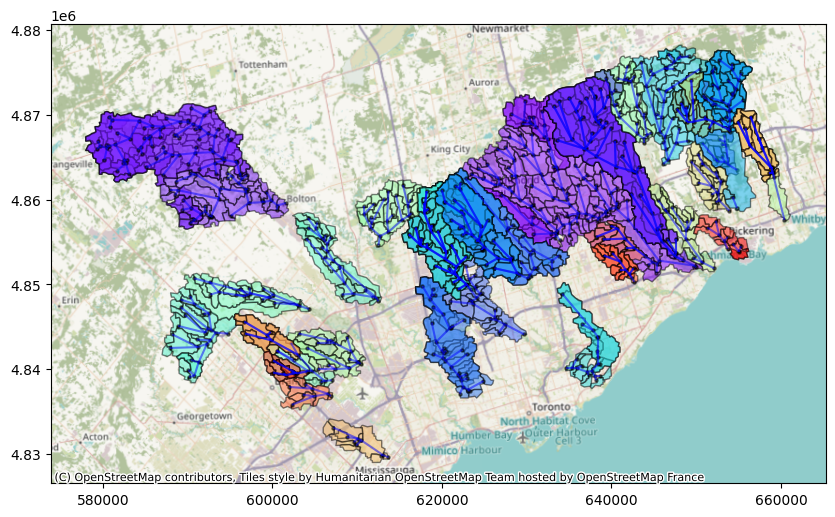

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for ii, (k, v) in enumerate(subcatchments.items()):
    v.plot(ax=ax, color=cmap(norm(ii)), edgecolor="black", label=k, alpha=0.5)
    nodes[k].plot(ax=ax, color="black", label=k, markersize=5, alpha=0.5)
    links[k].plot(ax=ax, color="blue", label=k, alpha=0.5)
ctx.add_basemap(ax, crs="epsg:26917")
plt.show()

In [156]:
list(subcatchments.keys())[28]

np.str_('HY065')

<Axes: >

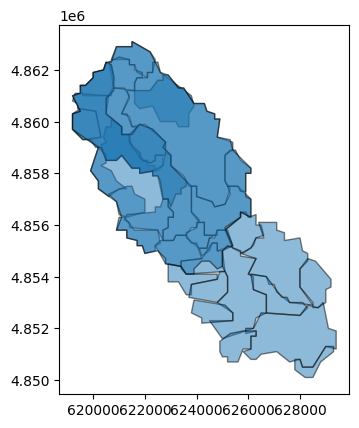

In [158]:
subcatchments[list(subcatchments.keys())[29]].plot(edgecolor="black", alpha=0.5)

In [ ]:
from utils.calparams import CalParam

cps = list()
cps.append(CalParam(section='infiltration', attribute='CurveNum', lower=1, upper=1, lower_bound=0, upper_bound=100, distributed=True))
cps.append(CalParam(section='subcatchments', attribute='Width', lower=0.5, upper=0.5, lower_bound=0.1, upper_bound=10**6, distributed=True))
#cps.append(CalParam(section='subcatchments', attribute='PercSlope', lower=1, upper=1, lower_bound=0, upper_bound=100, distributed=True))
cps.append(CalParam(section='subcatchments', attribute='Area', lower=1, upper=0, lower_bound=0, upper_bound=1E6, distributed=True))

from swmmio import Model
cps_distributed = []
for cp in cps:
    cps_distributed += cp.distribute(Model(str(model_file)))

# update the bounds relative to the initial values of each calibration parameter
cps_distributed = [cp.set_relative_bounds(upper=cp.upper, lower=cp.lower) for cp in cps_distributed]




HY035.rpt failed to initialize
negative seek position -168
HY035.rpt failed to initialize
negative seek position -168
HY035.rpt failed to initialize
negative seek position -168


In [4]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1.area)
    sim.execute()

from pyswmm import Output
from swmm.toolkit import shared_enum

with Output("test.out") as out:
    ok = out.node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)


print(ok)
shared_enum.NodeAttribute.TOTAL_INFLOW


1529.0

... SWMM Version 5.2.4
... Run Complete{datetime.datetime(2016, 2, 1, 0, 0): 0.06890132278203964}


<NodeAttribute.TOTAL_INFLOW: 4>

HY035.rpt failed to initialize
negative seek position -168


In [ ]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1)
    print(infiltration_params)

TypeError: 'PySWMM' object is not callable

In [ ]:
import os
spc = SimulationPreConfig()
spc.input_file = str(model_file)
spc.add_update_by_token("SUBCATCHMENTS", "s1", 3, 1321321000000)
spc.add_update_by_token("SUBCATCHMENTS", "s2", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s3", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s4", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s5", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s7", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s8", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s9", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s10", 3, 1321312000000)
spc.add_update_by_token("SUBCATCHMENTS", "s11", 3, 1321312000000)
spc.apply_changes()

with Simulation(str(model_file), sim_preconfig=spc, outputfile="test.out") as sim:
    S1 = Subcatchments(sim)["s1"]
    print(S1.area)
    sim.execute()

from pyswmm import Output
from swmm.toolkit import shared_enum

with Output("test.out") as out:
    ok = out.node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)


print(ok)
shared_enum.NodeAttribute.TOTAL_INFLOW

from utils.swmmutils import get_model_path

os.remove("test.out")


1321321000000.0

... SWMM Version 5.2.4

KeyboardInterrupt: 

In [166]:
import pandas as pd
pd.DataFrame(index=ok.keys(), data=ok.values()).plot()

NameError: name 'ok' is not defined

In [ ]:
with Simulation(str(model_file), outputfile="test.out") as sim:
    subcatchment_ids = [s.subcatchmentid for s in Subcatchments(sim)]
    ok = Subcatchments(sim)["s1"].__getattribute__("width")

ok


AttributeError: 'Subcatchment' object has no attribute 's'

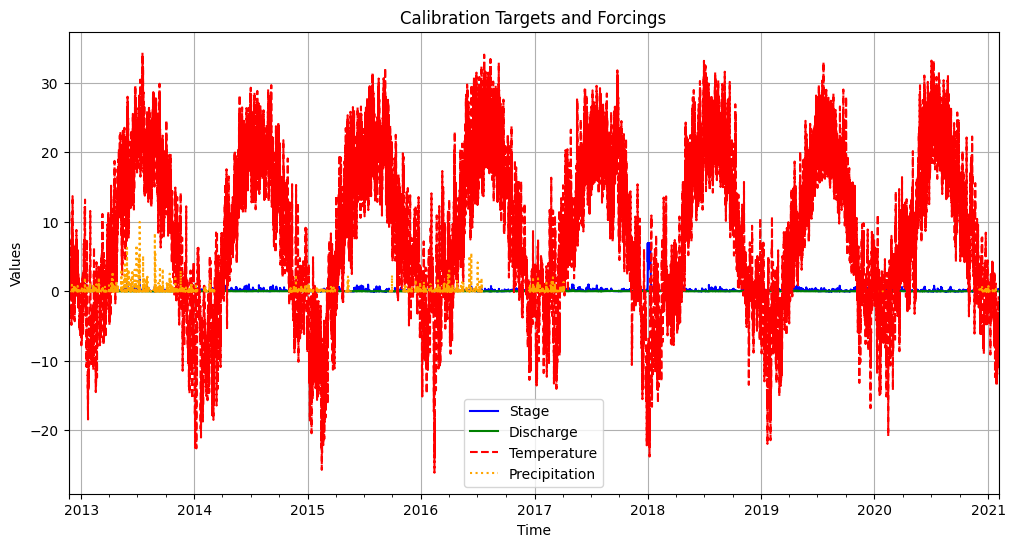

In [125]:
from utils.optconfig import OptConfig

oc = OptConfig(
    model_file = model_file,
    forcing_data_file = model_dir / station_id / "forcings.pkl",
    target_data_file = model_dir / station_id / "targets.pkl",
    run_folder = model_dir / station_id / "runs",
)

cal_targets = pd.read_pickle(oc.target_data_file)
cal_forcings = pd.read_pickle(oc.forcing_data_file)


fig, ax = plt.subplots(figsize=(12, 6))

# Plot cal_targets
cal_targets[("stage", station_id)].plot(ax=ax, label="Stage", color="blue")
cal_targets[("discharge", station_id)].plot(ax=ax, label="Discharge", color="green")

# Plot cal_forcings
cal_forcings[("temperature", station_id)].plot(ax=ax, label="Temperature", color="red", linestyle="--")
cal_forcings[("precipitation", station_id)].plot(ax=ax, label="Precipitation", color="orange", linestyle=":")

# Add labels, legend, and grid
ax.set_title("Calibration Targets and Forcings")
ax.set_xlabel("Time")
ax.set_ylabel("Values")
ax.legend()
ax.grid()
plt.show()


... SWMM Version 5.2.4
... Run Complete

In [ ]:
for ii in range(100):
    Output(str(model_file.with_suffix('.out'))).node_series("HY035", shared_enum.NodeAttribute.TOTAL_INFLOW)




... SWMM Version 5.2.4

Exception: 
  ERROR 307: cannot open binary results file.

<aenum 'NodeAttribute'>

AttributeError: 'WindowsPath' object has no attribute 'inp'

{datetime.datetime(2012, 1, 1, 0, 15): 0.0,
 datetime.datetime(2012, 1, 1, 0, 30): 0.0,
 datetime.datetime(2012, 1, 1, 0, 45): 0.0,
 datetime.datetime(2012, 1, 1, 1, 0): 0.0,
 datetime.datetime(2012, 1, 1, 1, 15): 0.0,
 datetime.datetime(2012, 1, 1, 1, 30): 0.0,
 datetime.datetime(2012, 1, 1, 1, 45): 0.0,
 datetime.datetime(2012, 1, 1, 2, 0): 0.0,
 datetime.datetime(2012, 1, 1, 2, 15): 0.0,
 datetime.datetime(2012, 1, 1, 2, 30): 0.0,
 datetime.datetime(2012, 1, 1, 2, 45): 0.0,
 datetime.datetime(2012, 1, 1, 3, 0): 0.0,
 datetime.datetime(2012, 1, 1, 3, 15): 0.0,
 datetime.datetime(2012, 1, 1, 3, 30): 0.0,
 datetime.datetime(2012, 1, 1, 3, 45): 0.0,
 datetime.datetime(2012, 1, 1, 4, 0): 0.0,
 datetime.datetime(2012, 1, 1, 4, 15): 0.0,
 datetime.datetime(2012, 1, 1, 4, 30): 0.0,
 datetime.datetime(2012, 1, 1, 4, 45): 0.0,
 datetime.datetime(2012, 1, 1, 5, 0): 0.0,
 datetime.datetime(2012, 1, 1, 5, 15): 0.0,
 datetime.datetime(2012, 1, 1, 5, 30): 0.0,
 datetime.datetime(2012, 1, 1, 5, 45)

In [ ]:
nodes = ["node1","node2"]
res = {node:[] for node in nodes}
dti = []

PARAM_MAPPING = {"discharge":"total_inflow","stage":"depth"}

with Simulation(str(model_file)) as sim:
    for step in sim:
        dti.append(sim.current_time)
        for node in nodes:
            res[node].append(getattr(Nodes(sim)[node],PARAM_MAPPING["discharge"]))



In [ ]:
from utils.calibutils import _validate_target_data
import pandas as pd
from swmmio import Model
tgt = pd.read_pickle(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY035\targets.pkl")
mdl = Model(str(model_file))

_validate_target_data(tgt, mdl)



True

'C:\\Users\\everett\\Documents\\GitHub\\camus_to\\data\\models\\swmm\\HY035\\targets.pkl'

In [ ]:
from swmmio import Model
mdl = Model(r"C:\Users\everett\Documents\GitHub\camus_to\data\models\swmm\HY095\HY095.inp")

from defs import SWMM_DATETIME_FMT


from utils.swmmutils import get_model_datetimes




In [ ]:
import pandas as pd
from pathlib import Path

tgt_stations = tgt.columns.get_level_values('station').unique().to_list()





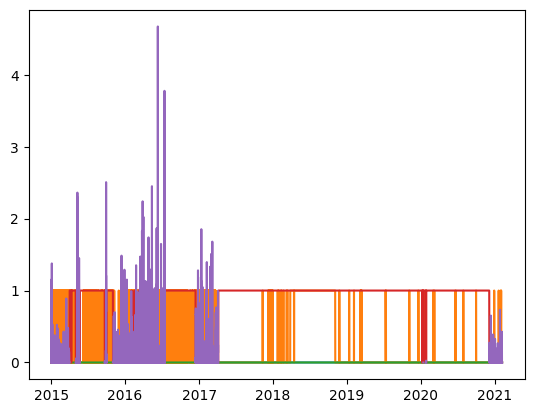

In [ ]:
plt.plot(df.isna())
plt.plot(df["precipitation"])

In [ ]:
import pandas as pd
df

,stage,discharge,temperature,precipitation
station,HY006,HY006,HY006,HY006
time,,,,
2015-01-01 00:15:00,0.252772,0.010861,-7.433333,0.000000
2015-01-01 00:30:00,0.254771,0.010996,-7.408333,0.000000
2015-01-01 00:45:00,0.256771,0.011030,-7.383333,0.000000
2015-01-01 01:00:00,0.259771,0.011064,-7.358333,0.000000
2015-01-01 01:15:00,0.261771,0.010928,-7.416667,0.095586
...,...,...,...,...
2021-02-05 18:00:00,0.275583,0.009178,-7.220000,0.000000
2021-02-05 18:15:00,0.275583,0.009114,-7.295000,0.000000
